In [57]:
input_json = r"C:\Users\Soushiyant\Desktop\input.json"

In [58]:
import json
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
from random import sample
from copy import deepcopy
from itertools import combinations

In [59]:
Image_out = False
write_print = False
#Define the Hyperparameters
nGene = 12
geneDomain = [0,1000]        #landscape size for center of building
nObjectives = 2               #number of Objectives
nPop = 100                  #number of Population
nCrossover = 80             #number of Crossover
nMutation = 20              #number of Mutation
nGeneration = 10

alpha = 200
beta = 10

#open JSON file
with open(input_json, 'r') as file:
    data = json.load(file)

NUM_BUILDINGS = len(data["buildings"])
NUM_Paths = len(data["paths"])
print(f"Buildings: {NUM_BUILDINGS} \nPaths: {NUM_Paths}")


#set_penalty
area_base = []
for i, building in enumerate(data["buildings"]):
    area_base.append(building["dimensions"][0]*building["dimensions"][1])
area_base_penalty=sum(area_base)*10

path_base = []
for i, building in enumerate(data["paths"]):
    path_base.append(building["max_length"])
path_base_penalty=sum(path_base)*10

Buildings: 3 
Paths: 2


In [60]:
def calculate_total_bounding_box(rectangles):

    min_x = min(rect.bounds[0] for rect in rectangles)
    min_y = min(rect.bounds[1] for rect in rectangles)
    max_x = max(rect.bounds[2] for rect in rectangles)
    max_y = max(rect.bounds[3] for rect in rectangles)

    return (min_x, min_y, max_x, max_y)

In [61]:
def calculate_objectives(data, genome):
    #Creat genome
    x_vector = genome[0:4]
    y_vector = genome[4:8]
    flip = np.array(genome[8:12]) > (geneDomain[1]-geneDomain[0])/2
    flip=flip.astype(int)  

    # OBJ 1
    rectangles = []
    buildings_moved = []
    x_y = []
    penalty_bbox = 0

    # Create rectangles for buildings
    for i in range(len(data["buildings"])):
        dim_rect = data['buildings'][i]["dimensions"]
        if flip[i]:
            dim_rect = list(reversed(dim_rect))
        rectangles.append(np.array([dim_rect[0] / 2 * -1, dim_rect[1] / 2 * -1, dim_rect[0] / 2, dim_rect[1] / 2]))

    # Move buildings based on vectors
    for i in range(len(data["buildings"])):
        vector = np.array([x_vector[i], y_vector[i], x_vector[i], y_vector[i]])
        moved_rectangle = rectangles[i] + vector
        x_y.append(moved_rectangle.tolist())
        buildings_moved.append(box(*moved_rectangle))

    # Calculate total bounding box
    bbox = calculate_total_bounding_box(buildings_moved)
    area_bbox = box(*bbox).area
    if write_print: print("area: ",area_bbox)
    
    # Check for intersections and calculate penalties
    for i, rect1 in enumerate(buildings_moved):
        for j, rect2 in enumerate(buildings_moved):
            if i >= j:
                continue
            if rect1.intersects(rect2):
                #print(f"Building {i + 1} and building {j + 1} have intersect")     
                penalty_bbox += 1
    
    obj1 =  area_base_penalty * penalty_bbox*10 + area_bbox

    # Path calculations
    penalty_path_exist = 0
    path_from = []
    path_to = []
    road_size = []
    path_shape = []
    roads = []

    for i in range(len(data["paths"])):
        path_from.append(buildings_moved[int(data["paths"][i]["between"][0][-1]) - 1])
        path_to.append(buildings_moved[int(data["paths"][i]["between"][1][-1]) - 1])

    for j in range(len(data["paths"])):
        xmin_xmin = path_from[j].bounds[0] < path_to[j].bounds[0]
        xmax_xmax = path_from[j].bounds[2] < path_to[j].bounds[2]
        ymin_ymin = path_from[j].bounds[1] < path_to[j].bounds[1]
        ymax_ymax = path_from[j].bounds[3] < path_to[j].bounds[3]

        xmin_xmax = path_from[j].bounds[0] < path_to[j].bounds[2]
        xmax_xmin = path_from[j].bounds[2] < path_to[j].bounds[0]
        ymin_ymax = path_from[j].bounds[1] < path_to[j].bounds[3]
        ymax_ymin = path_from[j].bounds[3] < path_to[j].bounds[1]

        # path type 1 -4

        if xmin_xmin and not xmax_xmax and xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and ymax_ymin:
            path_shape.append([path_to[j].bounds[2], path_from[j].bounds[3], path_to[j].bounds[2] + data["paths"][j]["width"], path_to[j].bounds[3]])
            #print("road type :1")

        elif not xmin_xmin and not xmax_xmax and not xmin_xmax and not xmax_xmin and ymin_ymin and not ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0] ,path_to[j].bounds[3], path_from[j].bounds[0], path_to[j].bounds[3]+data["paths"][j]["width"]])
            #print("road type :2")
        
        elif xmin_xmin and xmax_xmax and xmin_xmax and xmax_xmin and ymin_ymin and not ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[2] ,path_to[j].bounds[1] -data["paths"][j]["width"], path_to[j].bounds[2], path_to[j].bounds[1]])
            #print("road type :3")

        elif xmin_xmin and not xmax_xmax and xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and not ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0] -data["paths"][j]["width"], path_to[j].bounds[1], path_to[j].bounds[0], path_from[j].bounds[1]])
            #print("road type :4")
        
        # path type 5 -12

        elif not xmin_xmin and not xmax_xmax and xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and ymax_ymin:
            path_shape.append([path_to[j].bounds[2], path_from[j].bounds[3], path_to[j].bounds[2]+data["paths"][j]["width"], path_to[j].bounds[3]])
            #print("road type :5")
        
        elif xmin_xmin and xmax_xmax and xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and ymax_ymin:
            path_shape.append([path_to[j].bounds[0]-data["paths"][j]["width"], path_from[j].bounds[3], path_to[j].bounds[0], path_to[j].bounds[3]])
            #print("road type :6")

        elif not xmin_xmin and not xmax_xmax and not xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0], path_to[j].bounds[1]-data["paths"][j]["width"], path_from[j].bounds[0], path_to[j].bounds[1]])
            #print("road type :7")

        elif xmin_xmin and xmax_xmax and xmin_xmax and xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[2], path_to[j].bounds[1], path_to[j].bounds[2], path_to[j].bounds[1]+data["paths"][j]["width"]])
            #print("road type :8")

        elif not xmin_xmin and not xmax_xmax and not xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0], path_to[j].bounds[3], path_from[j].bounds[0], path_to[j].bounds[3]+data["paths"][j]["width"]])
            #print("road type :9")

        elif xmin_xmin and xmax_xmax and xmin_xmax and xmax_xmin and not ymin_ymin and not ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[2], path_to[j].bounds[3], path_to[j].bounds[2], path_to[j].bounds[3]+data["paths"][j]["width"]])
            #print("road type :10")

        elif not xmin_xmin and not xmax_xmax and xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and not ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[2], path_to[j].bounds[1], path_to[j].bounds[2]+data["paths"][j]["width"], path_from[j].bounds[1]])
            #print("road type :11")

        elif xmin_xmin and xmax_xmax and xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and not ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[0]-data["paths"][j]["width"], path_to[j].bounds[1], path_to[j].bounds[0], path_from[j].bounds[1]])
            #print("road type :12")

        # path type 13 -16

        elif not xmin_xmin and xmax_xmax and xmin_xmax and not xmax_xmin and ymin_ymin and ymax_ymax and ymin_ymax and ymax_ymin:
            path_shape.append([path_from[j].bounds[2], path_from[j].bounds[1], path_from[j].bounds[2]+data["paths"][j]["width"], path_to[j].bounds[0]])
            #print("road type :13")

        elif not xmin_xmin and not xmax_xmax and not xmin_xmax and not xmax_xmin and not ymin_ymin and ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_to[j].bounds[2], path_from[j].bounds[3], path_from[j].bounds[2], path_from[j].bounds[3]+data["paths"][j]["width"]])
            #print("road type :14")

        elif xmin_xmin and xmax_xmax and xmin_xmax and xmax_xmin and not ymin_ymin and ymax_ymax and ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[0], path_from[j].bounds[1]-data["paths"][j]["width"], path_to[j].bounds[0], path_from[j].bounds[1]])
            #print("road type :15")

        elif not xmin_xmin and xmax_xmax and xmin_xmax and not xmax_xmin and not ymin_ymin and not ymax_ymax and not ymin_ymax and not ymax_ymin:
            path_shape.append([path_from[j].bounds[0]-data["paths"][j]["width"], path_to[j].bounds[3], path_from[j].bounds[0], path_from[j].bounds[3]])
            #print("road type :16")


    #penalty_roads
    penalty_roads_lengh = 0
    penalty_road_intesect = 0
    lengh_final = []

    if len(path_shape) == len(data["paths"]):
        for k in range(len(data["paths"])):
            roads.append(box(*path_shape[k]))
            lengh = box(*path_shape[k]).bounds
            road_size.append([lengh[2] - lengh[0], lengh[3] - lengh[1]])
            x_size = road_size[k][0]
            y_size = road_size[k][1]

            if x_size > y_size:
                lengh_final.append(x_size)
                #print(f"Road size {data["paths"][k]["between"]} = {x_size}")
                if x_size < float(data["paths"][k]["min_length"]) or x_size > float(data["paths"][k]["max_length"]):
                    penalty_roads_lengh += 1
                
            else:
                lengh_final.append(y_size)
                #print(f"Road size {data["paths"][k]["between"]} = {y_size}")                
                if y_size < float(data["paths"][k]["min_length"]) or y_size > float(data["paths"][k]["max_length"]):
                    penalty_roads_lengh += 1
    else:
        penalty_path_exist += len(data["paths"]) - len(path_shape)



    buildings_and_roads = buildings_moved + roads

    for i, rect1 in enumerate(buildings_and_roads):
        for j, rect2 in enumerate(buildings_and_roads):
            if i >= j:
                continue
            if rect1.intersects(rect2):
                #print(f"Building {i + 1} and building {j + 1} have intersect")   
                penalty_road_intesect += 1

    penalty_road_intesect_final = max(0, penalty_road_intesect - penalty_bbox - len(data["paths"]) * 2)

    obj2 = (penalty_path_exist*10 + penalty_road_intesect_final*5 + penalty_roads_lengh) * path_base_penalty + sum(lengh_final)
    #print (penalty_path_exist, penalty_road_intesect_final, penalty_roads_lengh, path_base_penalty , sum(lengh_final))


    if Image_out:
        fig, ax = plt.subplots()
        for i in x_y:
            ax.add_patch( plt.Rectangle((i[0], i[1]), i[2] -i[0], i[3]-i[1], edgecolor='dimgray', facecolor='lightgray', linewidth=1))

        for i in path_shape:
            ax.add_patch( plt.Rectangle((i[0], i[1]), i[2] -i[0], i[3]-i[1], edgecolor='red', facecolor='none', linewidth=1))

        ax.set_xlim(bbox[0]- bbox[0]*0.2, bbox[2]+ bbox[2]*0.2)
        ax.set_ylim(bbox[1]- bbox[1]*0.2, bbox[3]+ bbox[3]*0.2)
        ax.set_aspect('equal')
        plt.show()
    
    return [obj1 , obj2 , lengh_final, area_bbox]

NSGA-II

In [62]:
class Agent:
    _pop = []
    all = []
    
    
    def __init__(self, genome=None):
        if genome:
            self.genome = np.array(genome)
        else:
            self.genome = np.random.uniform(geneDomain[0], geneDomain[1], nGene)
        
        # compute  [fitness1,fitness2]
        compute = calculate_objectives(data, self.genome)
        self.fitness = compute[0:2]
        self.data = compute[2:4]
        Agent._pop.append(self)
        Agent.all.append(self)
    
    @classmethod
    def run(cls):
        all_records = []
        # stochastic distribution (initialization)
        for _ in range(nPop):
            cls()
        
        # GA generations
        for it in range(nGeneration):
            # random selection & Crossover
            candidates = sample(cls._pop, nCrossover)
            for i in range(0, nCrossover, 2):
                parent1 = candidates[i]
                parent2 = candidates[i+1]
                parent1.blend_crossover(parent2)


            # random selection & mutation
            candidates = sample(cls._pop, nMutation)
            for i in candidates:
                i.mutate()
            



            # merge 
            # the merge happens inside the initializer (see line no.12)
            
            # sort 
            # 1) compute the non_dominated sortings (fronts)
            # ndf is a dictionary of fronts with a list on indices
            ndf = cls.non_dominated_sortings()
            
            # 2) compute the crowding distance (generates an attribute named cd)
            cls.cd(ndf)
            
            # 3) sort the population
            cls.sort_population()
            
            #truncate
            cls._pop = cls._pop[:nPop]
            
            
            
            # filter the front
            first_front = np.array([i.fitness for i in cls._pop if i.rank == 1])
            first_front_data = np.array([i for i in cls._pop if i.rank == 1])
            
            # plot the costs
            plt.scatter(first_front[:,0], first_front[:,1])
            first_front = np.array(sorted(first_front, key=lambda t: t[0]))
            plt.plot(first_front[:,0], first_front[:,1],'r--')
            plt.show()

            
            #save the best result & show information    
            
            print (f"Generation {it}:\nBest fitness = {cls._pop[0].fitness}") 
            print (f"Best genome = {cls._pop[0].genome} \n {'-'*50}")


        return first_front_data
    
                   
    @classmethod
    def non_dominated_sortings(cls):
        c = 1
        nds = {'front1':[]}
        n = len(cls._pop)
        
        for i in cls._pop:
            # each object receives three new attributes
            # domination list, dominated count, rank
            i.domination_list = []
            i.dominated_count = 0
            i.rank = None
        
        # first step: compute the domination list & domination count
        for i,j in combinations(range(n), 2):
            data1 = cls._pop[i]
            data2 = cls._pop[j]

            if all(d1 <= d2 for d1, d2 in zip(data1.fitness, data2.fitness)) and any(d1 < d2 for d1, d2 in zip(data1.fitness, data2.fitness)):
                # data1 dominates data2
                data1.domination_list.append(j)
                data2.dominated_count += 1
                
            elif all(d2 <= d1 for d2, d1 in zip(data2.fitness, data1.fitness)) and any(d2 < d1 for d2, d1 in zip(data2.fitness, data1.fitness)):
                # data2 dominates data1
                data2.domination_list.append(i)
                data1.dominated_count += 1
            
        
        # second step: compute the rank
        for i in range(n):
            if cls._pop[i].dominated_count == 0:
                nds['front1'].append(i)
                cls._pop[i].rank = 1
        
        
        while True:
            c += 1
            nds[f'front{c}'] = []

            for i in nds[f'front{c-1}']:
                data1 = cls._pop[i]
                for j in data1.domination_list:
                    data2 = cls._pop[j]
                    data2.dominated_count -= 1
                    if data2.dominated_count == 0:
                        nds[f'front{c}'].append(j)
                        data2.rank = c
            
                    
            if len(nds[f'front{c}']) == 0:
                del nds[f'front{c}']
                break
        
        return nds
    
    @classmethod
    def cd(cls, fronts):
        # generate a new instance attribute for crowding distance value
        for i in cls._pop:
            i.crowding_distance = None
        
        for front in fronts.values():
            # front is a list of indices
            n = len(front)
            
            if n>1:
                
                # method 1
                costs = np.vstack([cls._pop[k].fitness for k in front])
                # crowding distance matrix
                d = np.zeros((n, nObjectives))
                
                for j in range(nObjectives):
                    c = np.sort(costs[:,j])
                    idx = np.argsort(costs[:,j])
                    
                    # the fist and last items in a front should have inf crowding distance
                    d[idx[0]][j] = np.inf
                    d[idx[-1]][j] = np.inf
                    
                    for i in range(1,n-1):
                        d[idx[i]][j] = np.abs(c[i+1] - c[i-1]) / np.abs(c[0] - c[1])
                 
                
                # compute total crowding distance
                for i,j in enumerate(front):
                    cls._pop[j].crowding_distance = np.sum(d[i,:])
                
            else:
                cls._pop[front[0]].crowding_distance = np.inf
                   
    
    @classmethod
    def sort_population(cls):
        # first we sort based on crowding distance
        # and then we sort based on front
        cls._pop = sorted(cls._pop, key=lambda t: t.crowding_distance, reverse=True)
        cls._pop = sorted(cls._pop, key=lambda t: t.rank)
    
    
    def blend_crossover(self,other):
        gamma = np.random.uniform(-alpha, 1+alpha, nGene)
        offspring1 = gamma * self.genome + (1-gamma)*other.genome
        offspring2 = gamma * other.genome + (1-gamma)*self.genome
        
        # bound the offspring's gene to the defined domain
        offspring1[offspring1>geneDomain[1]] = geneDomain[1]
        offspring1[offspring1<geneDomain[0]] = geneDomain[0]
        offspring2[offspring2>geneDomain[1]] = geneDomain[1]
        offspring2[offspring2<geneDomain[0]] = geneDomain[0]
        
        [Agent(list(offspring1)), Agent(list(offspring2))]
    
    def mutate(self):
        temp_genome = deepcopy(self.genome)
        sigma = (geneDomain[1] - geneDomain[0]) / beta
        temp_genome[np.random.randint(0,nGene)] += np.random.normal(0,sigma)
        
        # bound the mutations individual to the defined value
        temp_genome[temp_genome>geneDomain[1]] = geneDomain[1]
        temp_genome[temp_genome<geneDomain[0]] = geneDomain[0]
        
        Agent(list(temp_genome))

C:\Users\Soushiyant\AppData\Local\Temp\ipykernel_10764\1277353100.py:165: RuntimeWarning: invalid value encountered in scalar divide
  d[idx[i]][j] = np.abs(c[i+1] - c[i-1]) / np.abs(c[0] - c[1])
C:\Users\Soushiyant\AppData\Local\Temp\ipykernel_10764\1277353100.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  d[idx[i]][j] = np.abs(c[i+1] - c[i-1]) / np.abs(c[0] - c[1])


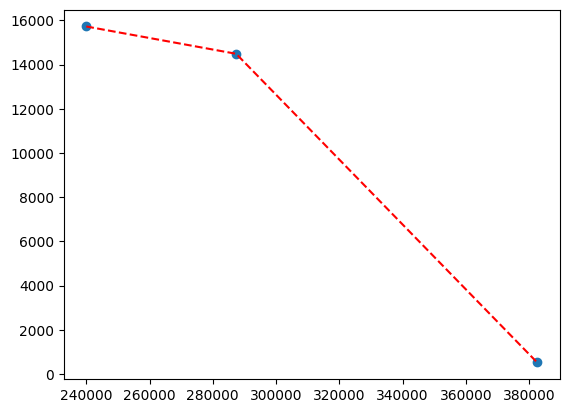

Generation 0:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


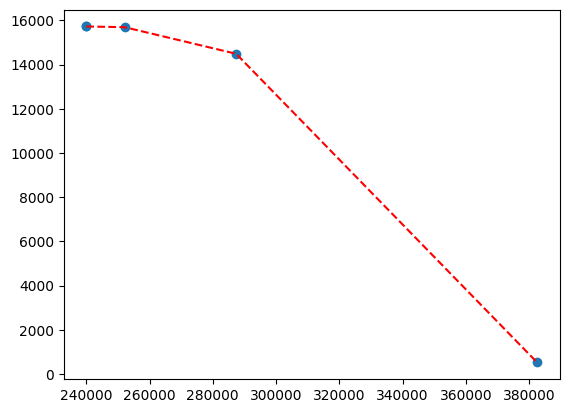

Generation 1:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


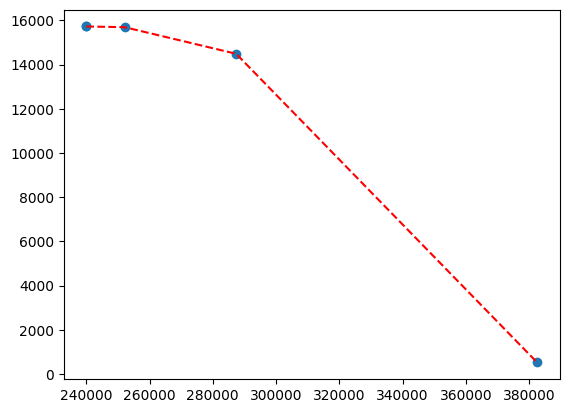

Generation 2:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


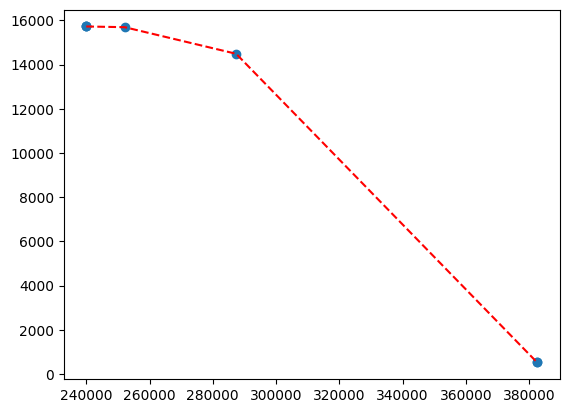

Generation 3:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


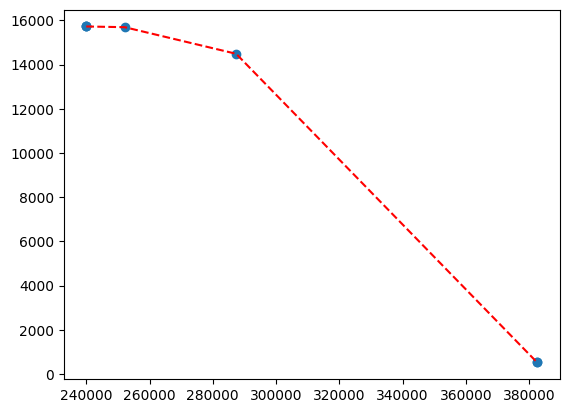

Generation 4:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


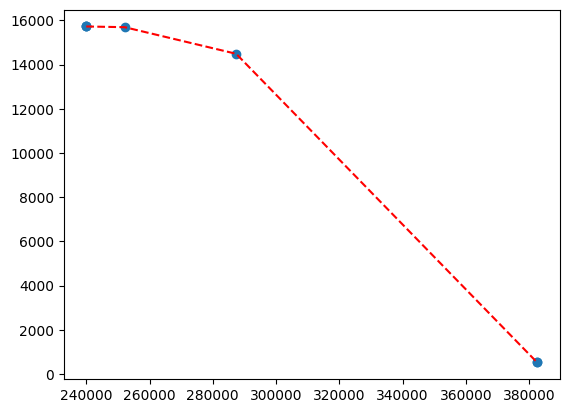

Generation 5:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


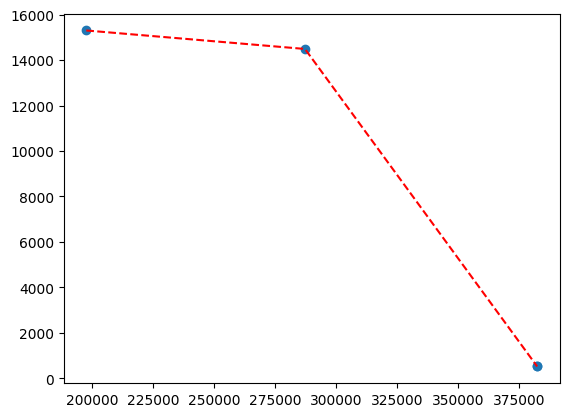

Generation 6:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


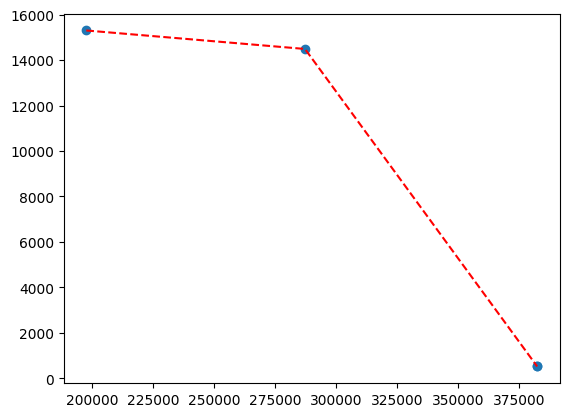

Generation 7:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


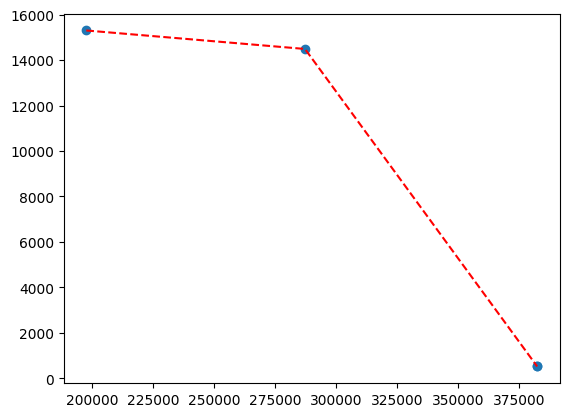

Generation 8:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


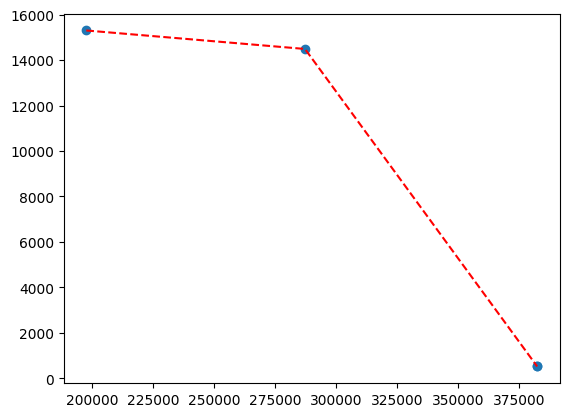

Generation 9:
Best fitness = [382566.84579192713, 516.0431677678768]
Best genome = [958.92314121 654.24552687 664.47166406  53.93011031 676.01966798
 947.61135859 513.25222149 710.97509793 587.88797357 887.71835617
 552.68689676 510.73334721] 
 --------------------------------------------------


In [63]:
parto_front = Agent.run()


[382566.84579192713, 516.0431677678768]


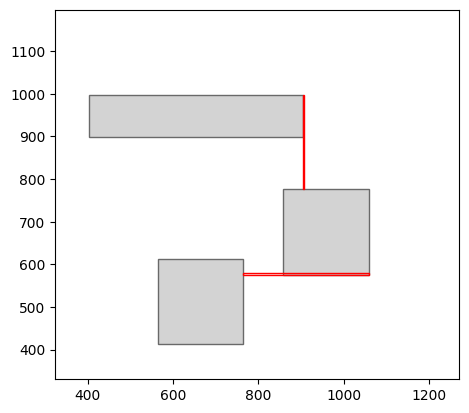

[287381.68522517534, 14490.52616358687]


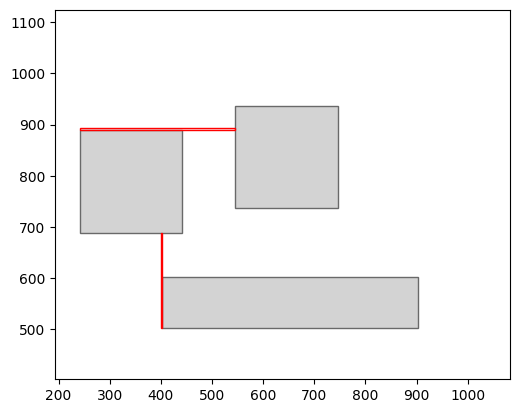

[382566.84579192713, 516.0431677678768]


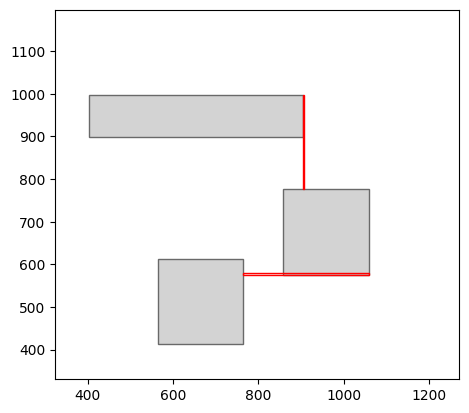

[197727.713459062, 15303.759597987588]


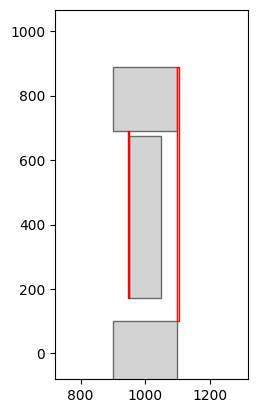

In [64]:
Image_out = True
for i in parto_front:
    print(i.fitness)
    calculate_objectives(data, i.genome )


In [65]:
solutions = []

for ag in range(len(Agent.all)):

    x_vector = Agent.all[ag].genome[0:4]
    y_vector = Agent.all[ag].genome[4:8]
    flip = Agent.all[ag].genome[8:12]
    flip = [0 if val <= geneDomain[1] / 2 else 1 for val in flip]

    buildings = []
    for i, building in enumerate(data["buildings"]):
        dim = building["dimensions"]
        if flip[i]:
            dim = list(reversed(dim))
        buildings.append({
            "name": building["name"],
            "location": [x_vector[i], y_vector[i]],
            "dimensions": dim,
            "area": Agent.all[ag].data[1]
        })

    # Prepare path data
    paths = []
    for n, path in enumerate(data["paths"]): 
        if len(Agent.all[ag].data[0]) == len(data["paths"]):
            l = Agent.all[ag].data[0]
        else:
            l = [None,None]
        paths.append({
            "name": path["name"],
            "connected_buildings": path["between"],
            "lengh":l[n] })


    solutions.append({
        "arrangement_id": ag,
        "buildings": buildings,
        "paths": paths,
        "objectives": {
            "objective 0": Agent.all[ag].fitness[0],
            "objective 1": Agent.all[ag].fitness[1] 
            

        }
    })


In [66]:
with open("out_task_GA.json", "w") as outfile:
    json.dump(solutions, outfile , indent=4)